#First attempt

## Import the data

In [1]:
import pandas as pd
import numpy as np

# reading
url="https://drive.google.com/file/d/1ljJfs1Rue1PRouBeZVl3DabqWRrfI8ZL/view?usp=share_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
data=df.copy()

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [46]:
X = df.drop(columns="poisonous")
y = df["poisonous"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## Data Exploration

In [47]:
X_train.head()

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population,Id
198,b,b,True,w,w,v,1832
4637,f,n,True,p,g,y,5006
3019,f,p,True,w,w,v,4040
2468,x,g,False,w,w,a,5533
6225,x,w,True,w,w,s,2710


In [48]:
X_train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5199 entries, 198 to 3582
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   cap.shape               5199 non-null   object
 1   cap.color               5199 non-null   object
 2   bruises                 5199 non-null   bool  
 3   stalk.color.above.ring  5199 non-null   object
 4   stalk.color.below.ring  5199 non-null   object
 5   population              5199 non-null   object
 6   Id                      5199 non-null   int64 
dtypes: bool(1), int64(1), object(5)
memory usage: 289.4+ KB


The only numeric columnn of our train set is "Id". Our column trandformer below will ignore it.

## Preprocessing the data

In [49]:
cat_col=X_train.select_dtypes(exclude = 'number').copy().columns # Extracting the names of columns
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),       # Our data set X_train has no missing value, but it might not be the case for  X_test
    OneHotEncoder(handle_unknown="ignore")
)  

numeric_pipe = make_pipeline(                                 #useful if we have meaningful nuemric columns
    SimpleImputer(strategy="mean"))

preprocessor = ColumnTransformer(transformers=[
    ('category', categoric_pipe, cat_col)
    #('number', numeric_pipe, num_col) # We ignore the numeric column
])

dt_pipeline = make_pipeline(preprocessor, 
                            #StandardScaler(with_mean=False) # no need to scale the onHotEncoded data
                           )

In [50]:
X_train_encoded=dt_pipeline.fit_transform(X_train)
X_train_encoded=pd.DataFrame(X_train_encoded.todense())


X_test_encoded=dt_pipeline.transform(X_test)
X_test_encoded=pd.DataFrame(X_test_encoded.todense())

## Neural network with 5 layers:
We have a binary classification problem, and therefore set the last activation to be the sigmoid function $f(x)=\frac{1}{1+\exp(-x)}$.

In [51]:
model = Sequential(
    [
        tf.keras.Input(shape=(42,)),
        Dense(units=30, activation='linear', name = 'layer1'),
        Dense(20, activation='relu', name = 'layer2'),
        Dense(5, activation='relu', name = 'layer3'),
        Dense(3, activation='linear', name = 'layer4'),
        Dense(1, activation='sigmoid', name = 'layer5')
     ]
)

In [52]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 30)                1290      
                                                                 
 layer2 (Dense)              (None, 20)                620       
                                                                 
 layer3 (Dense)              (None, 5)                 105       
                                                                 
 layer4 (Dense)              (None, 3)                 18        
                                                                 
 layer5 (Dense)              (None, 1)                 4         
                                                                 
Total params: 2,037
Trainable params: 2,037
Non-trainable params: 0
_________________________________________________________________


The binary cross entropy loss function $-y\log(\hat{y} )-(1-y)\log(1-\hat{y})$ works pretty well with binary classification problems. The optimizer Adam is faster.

In [53]:
model.compile(                                          #compiling the model
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
)

model.fit(                                              #fitting the model
    X_train_encoded,y_train,                            
    epochs=100,
)

Epoch 1/100
163/163 [==============================] - 1s 2ms/step - loss: 0.4769
Epoch 2/100
163/163 [==============================] - 0s 2ms/step - loss: 0.2123
Epoch 3/100
163/163 [==============================] - 0s 2ms/step - loss: 0.1417
Epoch 4/100
163/163 [==============================] - 0s 2ms/step - loss: 0.1261
Epoch 5/100
163/163 [==============================] - 0s 2ms/step - loss: 0.1178
Epoch 6/100
163/163 [==============================] - 0s 2ms/step - loss: 0.1094
Epoch 7/100
163/163 [==============================] - 0s 2ms/step - loss: 0.1047
Epoch 8/100
163/163 [==============================] - 0s 2ms/step - loss: 0.0998
Epoch 9/100
163/163 [==============================] - 0s 2ms/step - loss: 0.0984
Epoch 10/100
163/163 [==============================] - 0s 2ms/step - loss: 0.0971
Epoch 11/100
163/163 [==============================] - 0s 2ms/step - loss: 0.0948
Epoch 12/100
163/163 [==============================] - 0s 2ms/step - loss: 0.0955
Epoch 13/100


##Predictions of the model
The model is now ready to make predictions. 

In [54]:
predictions_train_set = model.predict(X_train_encoded)    #predictions for the train set
predictions_test_set = model.predict(X_test_encoded)      #prediction for the test set

41/41 [==============================] - 0s 1ms/step


Recall that the output of our model is a vector of real numbers, each representing the probability that a given mushroom (describe by the correcponding row in the data set) is poisonous. We set our decisive treshold to be equal to $0.1$: We classify a mushroom as poisonous if, and only if our model predicts that its probability to be poisonous is strictly greater than $0.1$. 

In [55]:
treshold=0.1
yhat_train=list((pd.DataFrame(predictions_train_set).iloc[:,0]>treshold).astype(int))
yhat_test=list((pd.DataFrame(predictions_test_set).iloc[:,0]>treshold).astype(int))

Overview of the predictions.

In [56]:
[(yhat_test[i],list(y_test)[i]) for i in range(20)]

[(1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (0, 0),
 (1, 1)]

## Model performence

We use the confusion matrix to evaluate the performence of our model. We compute: 
- $tn$: The number of true negatives. It corresponds to the number of eatable mushrooms that our model accurately classified.
- $fp$: The number of false positives. It corresponds to the number of eatable mushrooms that our model missclassified.
- $fn$: The number of false negatives. It corresponds to the number of poisonous mushrooms that our model missclassified.
- $tp$: The number of true positives. It corresponds to the number of poisonous mushrooms that our model accurately classified.

In [58]:
from sklearn.metrics import confusion_matrix
#confusion_matrix(list(y_test),list(yhat_test))
tn, fp, fn, tp = confusion_matrix(list(y_test),list(yhat_test)).ravel()
tn, fp, fn, tp

(604, 67, 0, 629)

In [15]:
#doind the task above manually
tp_test=sum([list(yhat_test)[i]*list(y_test)[i] for i in range(len(y_test))])
fp_test=sum([yhat_test[i]*(1-list(y_test)[i]) for i in range(len(y_test))])
tn_test=sum([(1-yhat_test[i])*(1-list(y_test)[i]) for i in range(len(y_test))])
fn_test=sum([(1-yhat_test[i])*list(y_test)[i] for i in range(len(y_test))])
tn_test,fp_test,fn_test,tp_test


(602, 69, 0, 629)

## Prepare the submission

In [16]:
# reading
url="https://drive.google.com/file/d/1rHAgVfd7vtZv3bj4Fb0MqS5PcRwOLC5I/view?usp=share_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df_testing = pd.read_csv(path)

data_testing=df_testing.copy()

X_testing_encoded=dt_pipeline.transform(data_testing)
X_testing_encoded=pd.DataFrame(X_testing_encoded.todense())
predictions_testing = model.predict(X_testing_encoded)
yhat_testing=list((pd.DataFrame(predictions_testing).iloc[:,0]>treshold).astype(int))

51/51 [==============================] - 0s 1ms/step


In [17]:
data_testing["poisonous"]=yhat_testing
result=data_testing[["Id","poisonous"]]
result.to_csv("attemp_x_Gauss.csv",index=False)


#Improvement?

In [18]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder,PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error,r2_score
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [19]:
# reading
url="https://drive.google.com/file/d/1ljJfs1Rue1PRouBeZVl3DabqWRrfI8ZL/view?usp=share_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_csv(path)
data=df.copy()

X = df.drop(columns="poisonous")
y = df["poisonous"]
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.4, random_state=123)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.5, random_state=123)


In [20]:
X_train.head()

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population,Id
6307,x,y,True,w,w,n,7464
2142,x,e,True,w,p,y,447
5608,f,y,True,w,w,s,5038
3030,x,y,False,p,p,v,5879
5460,x,w,False,w,w,a,6916


In [21]:
X_train.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3899 entries, 6307 to 3582
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   cap.shape               3899 non-null   object
 1   cap.color               3899 non-null   object
 2   bruises                 3899 non-null   bool  
 3   stalk.color.above.ring  3899 non-null   object
 4   stalk.color.below.ring  3899 non-null   object
 5   population              3899 non-null   object
 6   Id                      3899 non-null   int64 
dtypes: bool(1), int64(1), object(5)
memory usage: 217.0+ KB


In [22]:
#Preprocessing data
cat_col=X_train.select_dtypes(exclude = 'number').copy().columns # Extracting the names of columns
categoric_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="N_A"),       # Our data set X_train has no missing value, but it might not be the case for  X_test
    OneHotEncoder(handle_unknown="ignore")
)  

numeric_pipe = make_pipeline(                                 #useful if we have meaningful nuemric columns
    SimpleImputer(strategy="mean"))

preprocessor = ColumnTransformer(transformers=[
    ('category', categoric_pipe, cat_col)
    #('number', numeric_pipe, num_col) # We ignore the numeric column
])

In [23]:
dt_pipeline = make_pipeline(preprocessor, 
                            #PolynomialFeatures(degree=2,interaction_only=False, include_bias=True),
                            #StandardScaler(with_mean=False) # no need to scale the onHotEncoded data
                           )


X_train_encoded=dt_pipeline.fit_transform(X_train)
X_train_encoded=pd.DataFrame(X_train_encoded.todense())


X_test_encoded=dt_pipeline.transform(X_test)
X_test_encoded=pd.DataFrame(X_test_encoded.todense())

X_val_encoded=dt_pipeline.transform(X_val)
X_val_encoded=pd.DataFrame(X_val_encoded.todense())


In [24]:
X_train_encoded.shape

(3899, 41)

## Neural network with 5 layers:
We have a binary classification problem, and therefore set the last activation to be the sigmoid function $f(x)=\frac{1}{1+\exp(-x)}$.


In [25]:

model = Sequential(
    [
        tf.keras.Input(shape=(X_train_encoded.shape[1],)),
        Dense(units=45, activation='linear', name = 'layer0'),
     
        Dense(units=30, activation='sigmoid', name = 'layer1'),
        Dense(20, activation='relu', name = 'layer2'),
        Dense(5, activation='relu', name = 'layer3'),
        Dense(3, activation='linear', name = 'layer4'),
        Dense(1, activation='sigmoid', name = 'layer5')
     ]
)

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer0 (Dense)              (None, 45)                1890      
                                                                 
 layer1 (Dense)              (None, 30)                1380      
                                                                 
 layer2 (Dense)              (None, 20)                620       
                                                                 
 layer3 (Dense)              (None, 5)                 105       
                                                                 
 layer4 (Dense)              (None, 3)                 18        
                                                                 
 layer5 (Dense)              (None, 1)                 4         
                                                                 
Total params: 4,017
Trainable params: 4,017
Non-traina

The binary cross entropy loss function $-y\log(\hat{y} )-(1-y)\log(1-\hat{y})$ works pretty well with binary classification problems. The optimizer Adam is faster.

In [27]:
model.compile(                                          #compiling the model
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
     metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()]
)

model.fit(                                              #fitting the model
    X_train_encoded,y_train,                            
    epochs=100,
)


Epoch 1/100
122/122 [==============================] - 1s 2ms/step - loss: 0.9751 - binary_accuracy: 0.4891 - false_negatives: 0.0000e+00
Epoch 2/100
122/122 [==============================] - 0s 2ms/step - loss: 0.6767 - binary_accuracy: 0.5281 - false_negatives: 40.0000
Epoch 3/100
122/122 [==============================] - 0s 3ms/step - loss: 0.6024 - binary_accuracy: 0.7681 - false_negatives: 318.0000
Epoch 4/100
122/122 [==============================] - 0s 2ms/step - loss: 0.5477 - binary_accuracy: 0.8225 - false_negatives: 405.0000
Epoch 5/100
122/122 [==============================] - 0s 2ms/step - loss: 0.4906 - binary_accuracy: 0.8441 - false_negatives: 366.0000
Epoch 6/100
122/122 [==============================] - 0s 2ms/step - loss: 0.4437 - binary_accuracy: 0.8518 - false_negatives: 362.0000
Epoch 7/100
122/122 [==============================] - 0s 2ms/step - loss: 0.4079 - binary_accuracy: 0.8595 - false_negatives: 356.0000
Epoch 8/100
122/122 [==========================


##Predictions of the model
The model is now ready to make predictions. 

In [28]:
predictions_train_set = model.predict(X_train_encoded)    #predictions for the train set
predictions_val_set = model.predict(X_val_encoded)      #prediction for the val set
predictions_test_set = model.predict(X_test_encoded)      #prediction for the test set

41/41 [==============================] - 0s 2ms/step


Recall that the output of our model is a vector of real numbers, each representing the probability that a given mushroom (describe by the correcponding row in the data set) is poisonous. We set our decisive treshold to be equal to $0.25$: We classify a mushroom as poisonous if, and only if our model predicts that its probability to be poisonous is strictly greater than $0.25$. 

In [29]:
treshold=0.25
yhat_train=list((pd.DataFrame(predictions_train_set).iloc[:,0]>treshold).astype(int))
yhat_test=list((pd.DataFrame(predictions_test_set).iloc[:,0]>treshold).astype(int))
yhat_val=list((pd.DataFrame(predictions_val_set).iloc[:,0]>treshold).astype(int))


Overview of the predictions.

In [30]:
[(yhat_test[i],list(y_test)[i]) for i in range(20)]

[(1, 1),
 (0, 0),
 (1, 1),
 (0, 0),
 (1, 1),
 (0, 0),
 (0, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (0, 0),
 (0, 0),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 0),
 (0, 0)]



## Model performence

We use the confusion matrix to evaluate the performence of our model. We compute: 
- $tn$: The number of true negatives. It corresponds to the number of eatable mushrooms that our model accurately classified.
- $fp$: The number of false positives. It corresponds to the number of eatable mushrooms that our model missclassified.
- $fn$: The number of false negatives. It corresponds to the number of poisonous mushrooms that our model missclassified.
- $tp$: The number of true positives. It corresponds to the number of poisonous mushrooms that our model accurately classified.

In [31]:
from sklearn.metrics import confusion_matrix
#confusion_matrix(list(y_test),list(yhat_test))
tn_test, fp_test, fn_test, tp_test = confusion_matrix(list(y_test),list(yhat_test)).ravel()
tn_val, fp_val, fn_val, tp_val = confusion_matrix(list(y_val),list(yhat_val)).ravel()
fp_test+fn_test, fp_val+fn_val

(70, 56)

##Best treshold


In [32]:
def acc_treshol(y_1,y__1,y_2,y__2,y_3,y__3, ep):
  y_1_hat=list((pd.DataFrame(y_1).iloc[:,0]>ep).astype(int))
  y_2_hat=list((pd.DataFrame(y_2).iloc[:,0]>ep).astype(int))
  y_3_hat=list((pd.DataFrame(y_3).iloc[:,0]>ep).astype(int))

  tn_1, fp_1, fn_1, tp_1 = confusion_matrix(list(y__1),list(y_1_hat)).ravel()
  tn_2, fp_2, fn_2, tp_2 = confusion_matrix(list(y__2),list(y_2_hat)).ravel()
  tn_3, fp_3, fn_3, tp_3 = confusion_matrix(list(y__3),list(y_3_hat)).ravel()
  return fp_1+fn_1,fp_2+fn_2,fp_3+fn_3



In [33]:
acc_treshol(predictions_train_set,y_train,predictions_test_set,y_test,predictions_val_set,y_val, 0.005)

(495, 188, 174)

In [34]:
acc_train=[(100/len(X_train))*acc_treshol(predictions_train_set,y_train,predictions_test_set,y_test,predictions_val_set,y_val, i/100)[0] for i in range(1,100)]
acc_test=[(100/len(X_test))*acc_treshol(predictions_train_set,y_train,predictions_test_set,y_test,predictions_val_set,y_val, i/100)[1] for i in range(1,100)]
acc_val=[(100/len(X_val))*acc_treshol(predictions_train_set,y_train,predictions_test_set,y_test,predictions_val_set,y_val, i/100)[2] for i in range(1,100)]

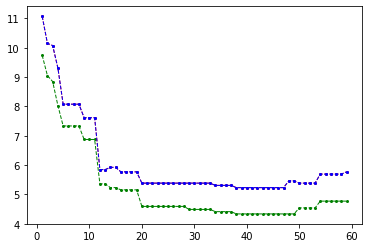

In [35]:
plt.plot(range(1,60), acc_train[1:60], color='green', marker='o', linestyle='dashed', linewidth=1, markersize=2)
plt.plot(range(1,60), acc_test[1:60], color='red', marker='o', linestyle='dashed', linewidth=1, markersize=2)
plt.plot(range(1,60), acc_test[1:60], color='blue', marker='o', linestyle='dashed', linewidth=1, markersize=2)

In [36]:
acc_treshol(predictions_train_set,y_train,predictions_test_set,y_test,predictions_val_set,y_val, 0.4)

(169, 68, 55)

Not very happy with the new model.  

In [40]:
treshold=0.4
yhat_test=list((pd.DataFrame(predictions_test_set).iloc[:,0]>treshold).astype(int))
tn_test, fp_test, fn_test, tp_test = confusion_matrix(list(y_test),list(yhat_test)).ravel()
tn_test, fp_test, fn_test, tp_test

(637, 48, 20, 595)

In the next attempt we will encode the data differently and create additional features.